In [6]:
# Deep Learning & ML
import tensorflow as tf
import tensorflow_probability as tfp
import keras as K
from keras import backend as Kback
from keras.models import Sequential
from keras import layers
from keras import utils as np_utils

# Linear Regression
from sklearn.linear_model import LinearRegression

# General
import numpy as np
import time

# Alerts
# import tkinter
# from tkinter import messagebox
import os as beepsnd

# General Outputs
print('TensorFlow:', tf.__version__)

TensorFlow: 2.1.0


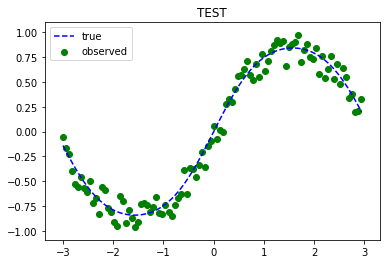

In [11]:
N_Reconfigurations = 10**1
d = 1 # Dimension of X
D = 1 # Dimension of Y

# Data Meta-Parameters
noise_level = 0.1
uncertainty_level= 0.9

# Training meta-parameters
Epochs = 10


# Number of Datapoints
N_data = 10**2
# Unknown Function
def unknown_f(x):
    return np.sin(np.sin(x))
%run Data_Generator.ipynb

In [12]:
class Reconfiguration_unit(tf.keras.layers.Layer):
    def __init__(self, *args, **kwargs):
        super(Reconfiguration_unit, self).__init__(*args, **kwargs)

    def build(self, input_shape):
        w_init = tf.random_normal_initializer()
        self.w = tf.Variable(initial_value=w_init(shape=(input_dim, units),
                                                  dtype='float32'),
                             trainable=True)

        self.weight = self.add_weight(shape=[input_shape[1],input_shape[1]], # CURRENTLY NOT A MATRIX FIX THIS!!!
                                    initializer='ones',
                                    trainable=True)
        self.bias = self.add_weight(shape=input_shape[1:],
                                    initializer='ones',
                                    trainable=True)
        self.location = self.add_weight(shape=input_shape[1:],
                                    initializer='ones',
                                    trainable=True)
        self.location_b = self.add_weight(shape=input_shape[1:],
                                    initializer='ones',
                                    trainable=True)
        self.scale = self.add_weight(shape=input_shape[1:],
                                    initializer='ones',
                                    trainable=True)
        
        
        
    def call(self, x):
        # 1. Shift and scale data
        x_shift = x - self.location
        
        # 2. Rescale componentwise
        x_mod = tf.math.multiply(x_shift,self.scale)
        
        # 3. Apply bumpy function Component-wise
        x_in_abs = tf.math.abs(x_mod)
        Logic_x_leq1 = tf.math.sign(tf.keras.activations.relu(1-x_in_abs)) # Takes value 1 iff |x|<=1 else 0: since probability of |x|=1 is 0 we should be ok
        x_thresheld = Logic_x_leq1*tf.math.exp(-1/(1-tf.math.pow(x_in_abs,-1))) # Computes bump function at thresholds with previous logic
        
        # 4+5. Apply Shift (In Tangent Space) and diagonalize
        x_out = tf.expand_dims((x_in_abs + self.bias), 1) 
        
        # 6. Multiply by weight matrix (in Tangent Space)
        x_out = (x_out * self.weight) 
        
        # 7. Apply Matrix Exponential
        x_out = tf.linalg.expm(x_out)
        
        # 8. Muliply by output of (1)
        x_out = tf.linalg.matvec(x_out,x_shift)
        
        # 9. Recenter Transformed Data
        x_out = x_out + self.location_b
        
        # Return Ouput
        return x_out

In [13]:
weight = tf.random.normal(shape = [d+D,d+D], mean = 0, stddev = 0.1)
bias = tf.random.normal(shape = [d+D,d+D], mean = 0, stddev = 0.1)
location = tf.ones(d+D)
location_b = -location
scale = tf.random.uniform(shape = [d+D], minval = (10**-5), maxval = (10**-1))
x = data_NEU[:1]

NameError: name 'data_NEU' is not defined

In [9]:
# 1. Shift and scale data
x_shift = x - location

# 2. Rescale componentwise
x_mod = tf.math.multiply(x_shift,scale)

# 3. Apply bumpy function Component-wise
x_in_abs = tf.math.abs(x_mod)
Logic_x_leq1 = tf.math.sign(tf.keras.activations.relu(1-x_in_abs)) # Takes value 1 iff |x|<=1 else 0: since probability of |x|=1 is 0 we should be ok
x_thresheld = Logic_x_leq1*tf.math.exp(-1/(1-tf.math.pow(x_in_abs,-1))) # Computes bump function at thresholds with previous logic

# 4+5. Apply Shift (In Tangent Space) and diagonalize
x_out = tf.linalg.diag(x_thresheld) + bias

# 6. Multiply by weight matrix (in Tangent Space)
x_out = tf.matmul(x_out,weight)

# 7. Apply Matrix Exponential
x_out = tf.linalg.expm(x_out)
  
# 8. Muliply by output of (1)
x_out = tf.linalg.matvec(x_out,x_shift)

# 9. Recenter Transformed Data
x_out = x_out + location_b

x_out

NameError: name 'x' is not defined

In [ ]:
class Reconfiguration_unit(K.layers.Layer):
    def __init__(self, *args, **kwargs):
        super(Reconfiguration_unit, self).__init__(*args, **kwargs)
        w_init = tf.random_normal_initializer()
        self.weight = tf.Variable(initial_value=w_init(shape=[d+D,d+D],
                                              dtype='float32'),
                                 trainable=True)
        b_init = tf.random_normal_initializer()
        self.bias = tf.Variable(initial_value=b_init(shape=[d+D,d+D],
                                              dtype='float32'),
                                 trainable=True)
        location_init = tf.random_normal_initializer()
        self.location = tf.Variable(initial_value=location_init(shape=[d+D,],
                                              dtype='float32'),
                                 trainable=True)
        self.location_b = tf.Variable(initial_value=location_init(shape=[d+D,],
                                              dtype='float32'),
                                 trainable=True)
        scale = tf.random_normal_initializer()
        self.scale = tf.Variable(initial_value=w_init(shape=[d+D,],
                                              dtype='float32'),
                                 trainable=True)
        
        #def build(self, input_shape):
        #self.weight = tf.Variable(initial_value=tf.random.normal(shape=[d+D,d+D]),
        #                                 trainable=True)
        #self.bias = self.add_weight(shape=input_shape[input_shape[1:],input_shape[1:]],
        #                            initializer=tf.random_normal_initializer(mean=0.0, stddev=0.1, seed=None),
        #                            trainable=True)
        #self.location = self.add_weight(shape=input_shape[1:],
        #                            initializer='ones',#tf.random_normal_initializer(mean=0.0, stddev=0.01, seed=None),
        #                            trainable=True)
        #self.location_b = self.add_weight(shape=input_shape[1:],
        #                            initializer='ones',#tf.random_normal_initializer(mean=0.0, stddev=0.1, seed=None),
        #                            trainable=True)
        #self.scale = self.add_weight(shape=input_shape[1:],
        #                            initializer='ones',#tf.random_normal_initializer(mean=0.0, stddev=0.1, seed=None),#tf.random_uniform_initializer(minval=(10**-5), maxval = (10**-1), seed=None),
        #                            trainable=True)
        
        
        
    def call(self, x):
        # 1. Shift and scale data
        x_shift = x - self.location

        # 2. Rescale componentwise
        x_mod = tf.math.multiply(x_shift,self.scale)

        # 3. Apply bumpy function Component-wise
        x_in_abs = tf.math.abs(x_mod)
        Logic_x_leq1 = tf.math.sign(tf.keras.activations.relu(1-x_in_abs)) # Takes value 1 iff |x|<=1 else 0: since probability of |x|=1 is 0 we should be ok
        x_thresheld = Logic_x_leq1*tf.math.exp(-1/(1-tf.math.pow(x_in_abs,-1))) # Computes bump function at thresholds with previous logic

        # 4+5. Apply Shift (In Tangent Space) and diagonalize
        x_out = tf.linalg.diag(x_thresheld) #+ self.bias

        # 6. Multiply by weight matrix (in Tangent Space)
        x_out = tf.matmul(x_out,self.weight)

        # 7. Apply Matrix Exponential
        x_out = tf.linalg.expm(x_out)

        # 8. Muliply by output of (1)
        x_out = tf.linalg.matvec(x_out,x_shift)

        # 9. Recenter Transformed Data
        x_out = x_out + self.location_b
        
        # Return Ouput
        return x_out